# Imports

In [299]:
%load_ext autoreload
%autoreload 2

# Pandas and numpy
import pandas as pd
import numpy as np

# Libraries for Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from src.visualization.visualize import plot_corr_matrix, plot_multi, plot_norm_dist, plot_feature_importances

# Alpaca API
import alpaca_trade_api as tradeapi

# Pickle
import pickle
import os

# To load variables from .env file into system environment
from dotenv import find_dotenv, load_dotenv

from atomm.Indicators import MomentumIndicators
from atomm.DataManager.main import MSDataManager
from src.visualization.visualize import plot_confusion_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load environment variables
load_dotenv(find_dotenv())

True

In [3]:
# Load dataset from pickle file
data_base_dir = os.environ.get('DATA_DIR_BASE_PATH')
fname = data_base_dir + '/processed/djia_cleaned_2019-12-11.pkl'
djia = pickle.load(open(fname, 'rb'))

In [4]:
#MomentumIndicators(MSDataManager().ReturnData('AAPL', limit=100)['Close']).calcMACD(12, 26,)

In [236]:
input_n = [3, 5, 7, 10, 15, 20, 25, 30]

# Target variable

## Next day close

In [5]:
djia.columns.get_level_values(0).unique()

Index(['AAPL', 'AXP', 'BA', 'CAT', 'CSCO', 'CVX', 'DIS', 'DOW', 'GS', 'HD',
       'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE',
       'PFE', 'PG', 'TRV', 'UNH', 'UTX', 'V', 'VZ', 'WBA', 'WMT', 'XOM',
       'DJIA'],
      dtype='object')

In [114]:
djia['IBM']['Close'].head()

Epoch
2014-12-04 00:00:00+00:00    164.050003
2014-12-05 00:00:00+00:00    163.270004
2014-12-08 00:00:00+00:00    161.860001
2014-12-09 00:00:00+00:00    162.990005
2014-12-10 00:00:00+00:00    160.509995
Name: Close, dtype: float32

In [6]:
dicti = {}
for x in djia.columns.get_level_values(0).unique():
    for n in input_n:
        diff = (djia[x]['Close'].shift(-n) - djia[x]['Close'])
        signal = np.where(diff > 0, 1, 0)
        dicti[x+'_signal'+str(n)] = signal

In [237]:
def create_signal_pct_change(data, symbol, threshold=0.01, multi=None):
    for n in input_n:
        if multi is None:
            multi = n
        diff = (data['Close'].shift(-n) - data['Close'])/data['Close']
        thr = threshold*multi
        signal1p = np.where(diff > thr, 1, 0)
        signal1n = np.where(diff < -thr, -1, 0)
        signal = signal1p + signal1n
        dicti[f'{symbol}_signal_{n}'] = signal

        #return signal1p, signal1n

In [242]:
dicti = {}
create_signal_pct_change(djia['AAPL'], 'AAPL', 0.01)

In [243]:
signals_true = pd.DataFrame(dicti)

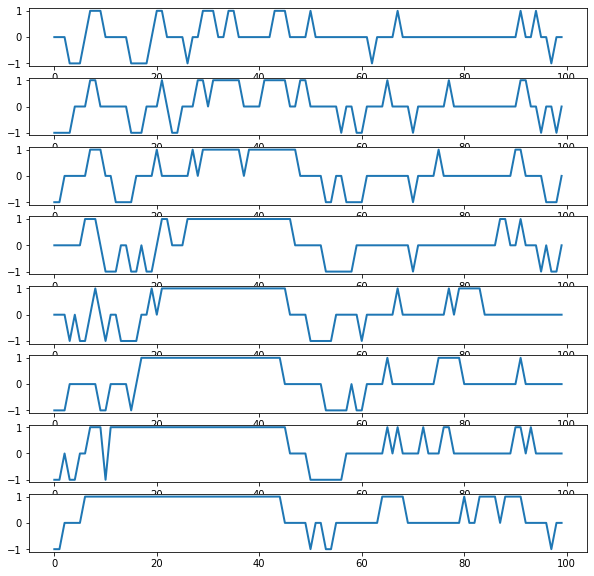

In [244]:
plt.figure(figsize=(10, 10))
colors = ['black', 'red', 'green', 'blue']
for i, n in enumerate(input_n):
    plt.subplot(len(input_n), 1, i+1)
    plt.plot(signals_true['AAPL_signal_'+str(n)][:100], lw=2, )#color=colors[n-1])
plt.show()


In [246]:
input_n

[3, 5, 7, 10, 15, 20, 25, 30]

In [320]:
y = signals_true

In [321]:
y.head()

,AAPL_signal_3,AAPL_signal_5,AAPL_signal_7,AAPL_signal_10,AAPL_signal_15,AAPL_signal_20,AAPL_signal_25,AAPL_signal_30
0,0,-1,-1,0,0,-1,-1,-1
1,0,-1,-1,0,0,-1,-1,-1
2,0,-1,0,0,0,-1,0,0
3,-1,-1,0,0,-1,0,-1,0
4,-1,0,0,0,0,0,-1,0


In [322]:
y.reset_index(inplace=True)

# Feature Engineering

Input window length:
[3, 5, 7, 10, 15, 20, 25, 30]

1. MACD x
2. RSI x
3. ROC x
4. BB x
5. SMA x
6. EMA x
7. ATR x
8. ADX x
9. CCI x
10. WILLIAMSR x
11. STOCK_n x
12. STOCD EMA_n(STOCK) x

In [104]:
def calcIndicators(data, symbol):
    mi = MomentumIndicators(data[symbol])
    df = pd.DataFrame(index=data.index)
    for n in input_n:
        # 1) MACD
        df[f'{symbol}_macd_{n}{2*n}'] = mi.calcMACD(n, 2*n)
        # 2) RSI
        df[f'{symbol}_rsi_{n}'] = mi.calcRSI(n)
        # 3) STOC
        df[f'{symbol}_stoc_{n}'] = mi.calcSTOC(n)
        # 4) ROC
        df[f'{symbol}_roc_{n}'] = mi.calcROC(n)
        # 5) Bollinger Bands
        df[f'{symbol}_bbu_{n}'], df[f'{symbol}_bbl_{n}'] = mi.calcBB(n)
        # 6) EMA
        df[f'{symbol}_ema_{n}'] = mi.calcEMA(n)
        # 7) ATR
        df[f'{symbol}_atr_{n}'] = mi.calcATR(n)
        # 8) ADX
        df[f'{symbol}_adx_{n}'] = mi.calcADX(n)
        # 9) CCI
        df[f'{symbol}_cci_{n}'] = mi.calcCCI(n)
        # 10) WilliamsR
        df[f'{symbol}_williamsr_{n}'] = mi.calcWR(n)
        # 11) STOCD
        df[f'{symbol}_stocd_{n}'] = mi.calcEMA(n, df[f'{symbol}_stoc_{n}'])
    return df


In [267]:
X = calcIndicators(djia, 'AAPL')

/Users/robin/Documents/temp/atomm/src/atomm/Indicators.py:129: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  latest = self.df['Close'].rolling(min_periods=1, window=n).apply(lambda x: x[-1:])
/Users/robin/Documents/temp/atomm/src/atomm/Indicators.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[f'roc_{n}'] = N / D
/Users/robin/Documents/temp/atomm/src/atomm/Indicators.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [269]:
X.tail()

,AAPL_macd_36,AAPL_rsi_3,AAPL_stoc_3,AAPL_roc_3,AAPL_bbu_3,AAPL_bbl_3,AAPL_ema_3,AAPL_atr_3,AAPL_adx_3,AAPL_cci_3,...,AAPL_stoc_30,AAPL_roc_30,AAPL_bbu_30,AAPL_bbl_30,AAPL_ema_30,AAPL_atr_30,AAPL_adx_30,AAPL_cci_30,AAPL_williamsr_30,AAPL_stocd_30
Epoch,,,,,,,,,,,,,,,,,,,,,
2019-11-27 00:00:00+00:00,0.949406,79.647823,100.000000,0.023149,271.407410,264.272583,266.106173,4.336670,30.354829,100.000000,...,100.000000,0.142808,288.530754,247.149239,254.942100,3.824665,34.275236,90.304217,0.464048,94.823906
2019-11-29 00:00:00+00:00,0.923253,57.074028,83.380328,0.003304,271.054564,263.445436,266.678086,3.483337,33.265621,50.209146,...,98.122824,0.135881,286.987788,247.512212,255.736158,3.806999,34.397893,87.604865,2.224859,95.036740
2019-12-02 00:00:00+00:00,0.119877,49.100932,0.000000,-0.000492,268.112937,260.207071,265.419045,3.529999,19.402720,-100.000000,...,86.800595,0.117381,282.626653,245.693354,256.279632,3.857331,32.536081,71.969522,13.197792,94.505376
2019-12-03 00:00:00+00:00,-1.193452,0.000000,0.000000,-0.031325,267.305877,251.594148,262.434529,3.869995,29.695304,-100.000000,...,69.906789,0.078749,276.834267,242.065758,256.484172,3.861664,33.016843,10.273487,28.396212,92.918370
2019-12-04 00:00:00+00:00,-1.001295,22.695597,48.619579,-0.020617,266.450580,257.029400,262.087259,4.456655,20.276281,1.062958,...,75.263564,0.090765,277.825339,245.654642,256.823257,3.904330,31.587192,38.818693,21.006804,91.779350


In [270]:
y.shape

(1259, 2)

In [278]:
X.shape

(1259, 96)

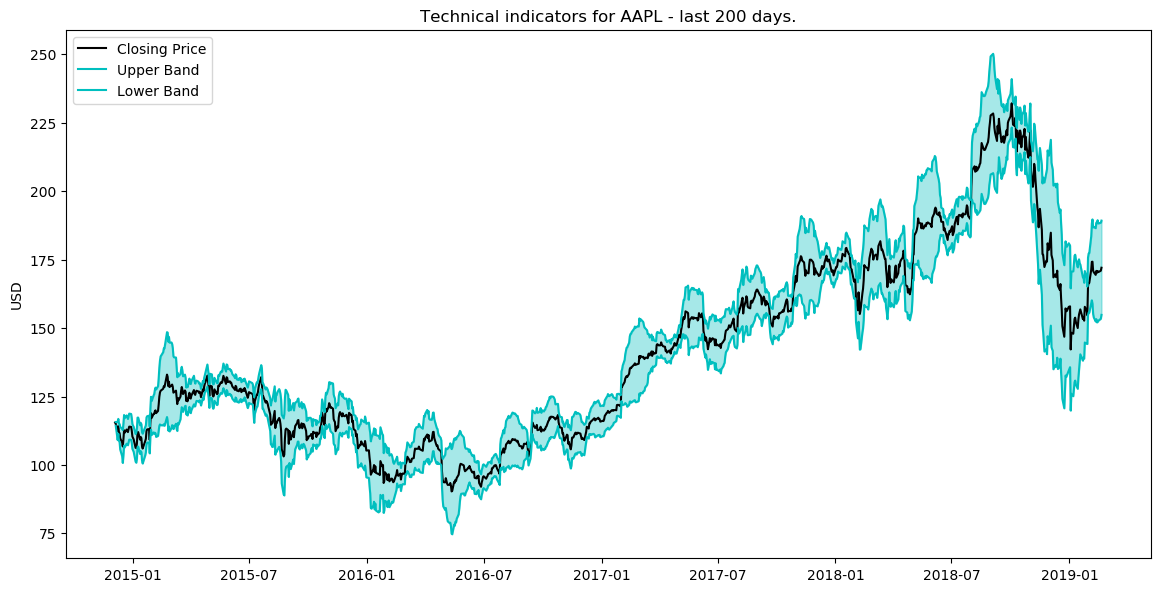

In [277]:
symbol = 'AAPL'

x_ = range(3, X.shape[0])
x_ = list(X.index)

last_days = 200
n = 30
#plt.fill_between()
plt.figure(figsize=(14, 7), dpi=100)
#plt.plot(dataset['ma7'], label='MA 7', color='g',linestyle='--')
plt.plot(djia[symbol]['Close'][:-last_days], label='Closing Price', color='k')
#plt.plot(X[symbol+'_macd1'],label='MACD 12, 26', color='r',linestyle='--')
plt.plot(X[f'{symbol}_bbu_{n}'][:-last_days], label='Upper Band', color='c')
plt.plot(X[f'{symbol}_bbl_{n}'][:-last_days], label='Lower Band', color='c')
plt.fill_between(X.index[:-last_days], X[f'{symbol}_bbu_{n}'][:-last_days], X[f'{symbol}_bbl_{n}'][:-last_days], color='c', alpha=0.35)
plt.title(f'Technical indicators for {symbol} - last {last_days} days.')
plt.ylabel('USD')
plt.legend()

In [16]:
#sns.pairplot(X.fillna(0))

In [287]:
X.fillna(0, inplace=True)

## Scaling the features

In [288]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [289]:
scale = MinMaxScaler()
scale = StandardScaler()

In [290]:
scaled = scale.fit_transform(X)

In [291]:
scaled.shape

(1259, 96)

In [292]:
X_scaled = pd.DataFrame(data=scaled, columns=X.columns)
#X_scaled = X

In [47]:
X_scaled.describe()

,AAPL_macd1,AAPL_macd2,AAPL_macd3,AAPL_rsi1,AAPL_rsi2,AAPL_rsi3,AAPL_stoc1,AAPL_stoc2,AAPL_stoc3,AAPL_roc1,AAPL_roc2,AAPL_roc3
count,1.249000e+03,1249.000000,1.249000e+03,1.249000e+03,1.249000e+03,1.249000e+03,1.249000e+03,1.249000e+03,1.249000e+03,1.249000e+03,1.249000e+03,1.249000e+03
mean,2.275557e-17,0.000000,-2.844447e-17,6.257782e-17,-2.730669e-16,1.820446e-16,1.991113e-17,-6.257782e-17,-2.560002e-17,5.688893e-18,5.688893e-18,8.533340e-18
std,1.000401e+00,1.000401,1.000401e+00,1.000401e+00,1.000401e+00,1.000401e+00,1.000401e+00,1.000401e+00,1.000401e+00,1.000401e+00,1.000401e+00,1.000401e+00
min,-3.858537e+00,-4.120314,-4.394093e+00,-2.621480e+00,-2.443091e+00,-2.170183e+00,-1.550771e+00,-1.488463e+00,-1.412843e+00,-3.716106e+00,-3.646270e+00,-3.442847e+00
25%,-4.839040e-01,-0.490307,-5.142726e-01,-7.276100e-01,-7.318527e-01,-7.530104e-01,-9.927371e-01,-1.014049e+00,-1.108519e+00,-5.887315e-01,-5.714726e-01,-5.601826e-01
50%,5.236191e-02,0.056250,8.245922e-02,2.866840e-02,2.227947e-02,3.763626e-02,2.668443e-01,2.221523e-01,2.277517e-01,8.238551e-02,5.339986e-02,5.057112e-02
75%,6.125424e-01,0.638424,5.977331e-01,7.770995e-01,7.632262e-01,8.214208e-01,1.068074e+00,1.072603e+00,1.059940e+00,6.175318e-01,6.049279e-01,5.981738e-01
max,2.617292e+00,2.536155,2.437421e+00,2.042280e+00,1.946607e+00,1.738600e+00,1.074672e+00,1.072603e+00,1.059940e+00,3.142789e+00,3.416403e+00,3.656447e+00


## Building Machine Learning Models

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit


### Preparing Data

In [323]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled.values, y['AAPL_signal_30'], test_size=.3, random_state=101)

### LogisticRegression

In [324]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=25, solver='newton-cg')
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))

              precision    recall  f1-score   support

          -1       0.47      0.31      0.37        88
           0       0.46      0.37      0.41       104
           1       0.62      0.80      0.70       186

    accuracy                           0.56       378
   macro avg       0.52      0.49      0.49       378
weighted avg       0.54      0.56      0.54       378

[[ 27  21  40]
 [ 16  38  50]
 [ 15  23 148]]


### RandomForestClassifier

              precision    recall  f1-score   support

          -1       0.92      0.89      0.90        88
           0       0.85      0.81      0.83       104
           1       0.93      0.97      0.95       186

    accuracy                           0.90       378
   macro avg       0.90      0.89      0.89       378
weighted avg       0.90      0.90      0.90       378

[[ 78   9   1]
 [  7  84  13]
 [  0   6 180]]


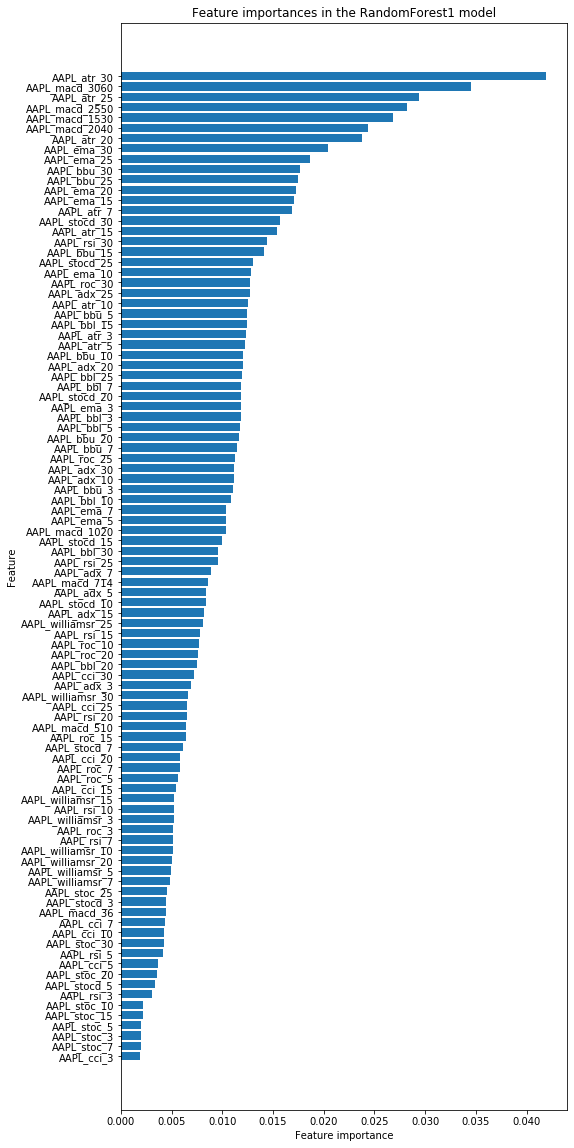

In [325]:
from sklearn.ensemble import RandomForestClassifier
rf1 = RandomForestClassifier()
rf1.fit(X_train, y_train)
y_pred_rf1 = rf1.predict(X_test)
print(classification_report(y_test, y_pred_rf1))
print(confusion_matrix(y_test, y_pred_rf1))
plot_feature_importances(rf1.feature_importances_, X_scaled.columns, model='RandomForest1', top_count=100)

In [294]:
#TimeSeriesSplit
#X_train, X_test, y_train, y_test = (X.values, y['AAPL_signal4'], test_size=.3, random_state=101)